In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy import interpolate, optimize
import helper
import os
from matplotlib.lines import Line2D

In [2]:
fit_results_path = '../model_fit_results'
exp_measures = pd.read_csv('../data/measures.csv')

In [3]:
def get_psf_ci(data):
    # psf: psychometric function
    # ci: dataframe with confidence intervals for probability per coherence
    tta_conditions = np.sort(data.tta_condition.unique())
    
    psf = np.array([len(data[(data.is_turn_decision) & (data.tta_condition==tta_condition)]) 
                                            / len(data[data.tta_condition==tta_condition]) 
                        if len(data[(data.tta_condition==tta_condition)]) > 0 else np.NaN 
                    for tta_condition in np.sort(data.tta_condition.unique())])

    ci = pd.DataFrame(psf, columns=['p_turn'], index=tta_conditions)

    n = [len(data[(data.tta_condition==tta_condition)]) for tta_condition in tta_conditions]
    ci['ci_l'] = ci['p_turn'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_turn'] + np.sqrt(psf*(1-psf)/n)

    return ci.reset_index().rename(columns={'index': 'tta_condition'})

def get_mean_sem(data, var='RT', n_cutoff=2):
    mean = data.groupby('tta_condition')[var].mean()
    sem = data.groupby('tta_condition')[var].apply(lambda x: scipy.stats.sem(x, axis=None, ddof=0))
    n = data.groupby('tta_condition').size()
    data_mean_sem = pd.DataFrame({'mean': mean, 'sem': sem, 'n': n}, index=mean.index)
    data_mean_sem = data_mean_sem[data_mean_sem.n>n_cutoff]
    return data_mean_sem

# Model diagram

In [4]:
def get_trace(t, dt, tta, d, model_params):  
    noise = np.random.randn(len(t))
    drift = model_params['alpha']*(tta+ model_params['beta']*d - model_params['theta'])
    dx = drift * simulation_params['dt'] +  model_params['noise'] * noise * np.sqrt(simulation_params['dt'])
    x = np.append([0], np.cumsum(dx)[:-1])    
    boundary = model_params['b_0']/(1+np.exp(-model_params['k']*(tta-model_params['tta_crit'])))
    response_time_idx = np.where(abs(x)>boundary)
    if len(response_time_idx[0])>0:
        return(x[:response_time_idx[0][0]+1])
    else:
        return(x)
    
def generate_model_traces(t, dt, tta, d, model_params):
    is_two_correct = False
    is_rt_ok = False
    while not(is_two_correct) or not(is_rt_ok):
        trials = [get_trace(t, dt, tta, d, model_params) for i in range(3)]
        is_two_correct = (np.sum([1 if x[-1]>0 else 0 for x in trials]) == 2)
        rts = [model_params['ndt_location']+len(trial)*dt for trial in trials]
        is_rt_ok = all([(rt>0.4) & (rt<0.7) for rt in rts])
    pd.DataFrame(trials).to_csv('ddm_traces.csv')

In [6]:
model_params = pd.read_csv('../model_fit_results/full_data_parameters_fitted.csv')
all_subj_params = model_params[model_params.subj_id=='all'].to_dict('records')[0]
all_subj_params['ndt_location'] -= 0.15
simulation_params = {'dt': 0.0001, 'duration': 1}

### Plot TTA+$\beta$d

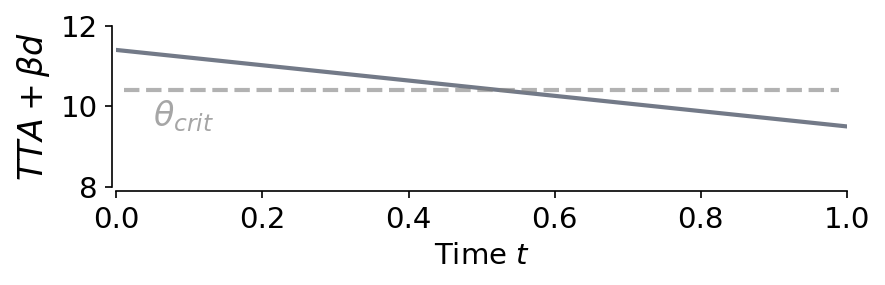

In [10]:
fig, ax_rate = plt.subplots(1, 1, figsize=(6,2), dpi=150)

condition = {'tta': 6, 'd': 120}
dt = simulation_params['dt']
t = np.arange(0, simulation_params['duration'], dt)
d = condition['d'] - (condition['d'] / condition['tta'])*t
tta = condition['tta'] - t
ndt = model_params['ndt_location']

ax_rate.plot(t, tta+all_subj_params['beta']*d, color='#50596A', alpha=0.8)
ax_rate.axhline(all_subj_params['theta'], color='grey', alpha=0.6, ls='--', xmin=0.01, xmax=0.99)
ax_rate.set_ylabel(r'$TTA + \beta d$', fontsize=16)
ax_rate.set_xlim((0,1))
ax_rate.set_xlabel(r'Time $t$', fontsize=14)
ax_rate.set_ylim((8,12))
ax_rate.text(0.05, 9.5, r'$\theta_{crit}$', color='grey', alpha=0.7, fontsize=16)

sns.despine(offset=2, trim=True)
plt.tight_layout()
plt.savefig('../output/tta_d.png', bbox_inches='tight')

In [25]:
def plot_model_traces(model_params, simulation_params, generate_new=False):
    colors = {'turn': '#4052ac', 'wait': '#e6263d', 'equation': '#50596A'}
    condition = {'tta': 6, 'd': 120}
    dt = simulation_params['dt']
    t = np.arange(0, simulation_params['duration'], dt)
    d = condition['d'] - (condition['d'] / condition['tta'])*t
    tta = condition['tta'] - t
    ndt = model_params['ndt_location']

    if generate_new:
        generate_model_traces(t, dt, tta, d, model_params)        
    trials = [x[1][~x[1].isna()].values[1:] for x in pd.read_csv('ddm_traces.csv').iterrows()]
    
    fig, (ax_rate, ax) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [1, 3]}, dpi=150, sharex=True)
    
    ax_rate.plot(t+ndt, tta+model_params['beta']*d, color='#50596A', alpha=0.8)
    ax_rate.axhline(model_params['theta'], color='grey', alpha=0.6, ls='--', xmin=0.01, xmax=0.99)
    ax_rate.set_ylabel(r'$TTA + \beta d$', fontsize=16)
    ax_rate.set_xlim((0,1))
    ax_rate.set_ylim((8,12))
    ax_rate.text(0.05, 9.5, r'$\theta_{crit}$', color='grey', alpha=0.7, fontsize=16)

    ax.set_xlabel(r'Time $t$', fontsize=14)
    ax.set_ylabel(r'Accumulated evidence $x$', fontsize=14)
    ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
    ax.set_ylim((-0.7, 0.7))

    sns.despine(offset=2, trim=True)
    plt.tight_layout()
    plt.savefig('../output/fig_model_diagram_1.png', bbox_inches='tight')
    
    ax.text(0.01, 0.04, 'Non-decision time', color=colors['equation'], fontsize=13)
    ax.plot([0, ndt], [0,0], lw=1, color=colors['equation'])
    ax.vlines(x=[0, ndt-0.002], ymin=-0.02, ymax=0.09, ls='--', color=colors['equation'], lw=1)
    plt.tight_layout()
    plt.savefig('../output/fig_model_diagram_2.png', bbox_inches='tight')

    ax.annotate('', xy=(ndt,0), xytext=(ndt+0.2, 0.15),
                 arrowprops=dict(arrowstyle='<-', connectionstyle='arc3', color=colors['equation'], linewidth=2))
    ax.text(0.43, 0.02, r'$dx = \alpha(TTA + \beta d - \theta_{crit}) dt + dW$', color=colors['equation'], fontsize=16)
    
    plt.tight_layout()
    plt.savefig('../output/fig_model_diagram_3.png', bbox_inches='tight')

    ax.text(0.47, 0.6, 'Turn', color=colors['turn'], alpha=0.7, fontsize=16)
    ax.text(0.47, -0.65, 'Wait', color=colors['wait'], alpha=0.7, fontsize=16)
    for tta_condition in [6, 4]:
        boundary = model_params['b_0']/(1+np.exp(-model_params['k']*(tta_condition-t-model_params['tta_crit'])))            
        ax.plot(t+ndt, boundary, ls='--', color='gray', alpha=0.6)
        ax.plot(t+ndt, -boundary, ls='--', color='gray', alpha=0.6)
        ax.text(0.78, 0.3+0.15*(tta_condition-4), r'TTA$|_{t=0}$=%is' % (tta_condition), 
                color=colors['equation'], alpha=0.6, fontsize=16)
        if tta_condition==6:
            plt.savefig('../output/fig_model_diagram_4.png', bbox_inches='tight')
    
    plt.tight_layout()
    plt.savefig('../output/fig_model_diagram_5.png', bbox_inches='tight')

    for x in trials:
        color = colors['turn'] if x[-1]>0 else colors['wait']
        ax.plot(t[:len(x)]+ndt, x, lw=1.0, alpha=0.4, color=color)
    plt.tight_layout()
    plt.savefig('../output/fig_model_diagram_6.png', bbox_inches='tight')
    for x in trials:
        color = colors['turn'] if x[-1]>0 else colors['wait']
        ax.plot(t[len(x)]+ndt, x[-1], ls='', alpha=0.8, marker='o', ms=4, color=color)
        
        tta_condition=4
        boundary = model_params['b_0']/(1+np.exp(-model_params['k']*(tta_condition-t-model_params['tta_crit'])))
        response_time_idx = np.where(abs(x)>boundary[:len(x)])[0][0]
        ax.plot(t[response_time_idx]+ndt, x[response_time_idx], ls='', alpha=0.5, 
                        marker='o', ms=4, color=color)

    plt.tight_layout()
    plt.savefig('../output/fig_model_diagram_final.png', bbox_inches='tight')

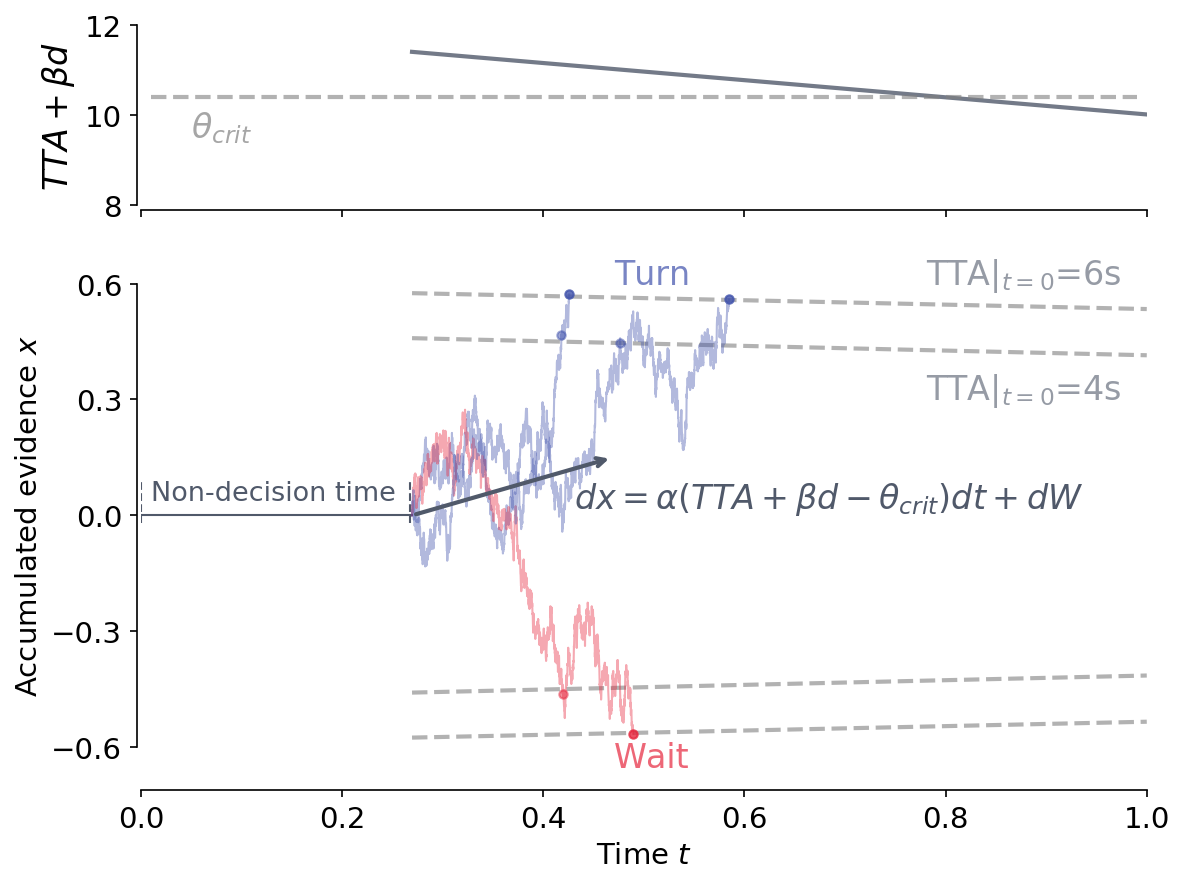

In [26]:
model_params = pd.read_csv('../model_fit_results/full_data_parameters_fitted.csv')
all_subj_params = model_params[model_params.subj_id=='all'].to_dict('records')[0]
all_subj_params['ndt_location'] -= 0.15
simulation_params = {'dt': 0.0001, 'duration': 1}

plot_model_traces(all_subj_params, simulation_params, generate_new=False)

# Trial timeline

In [142]:
exp_data = pd.read_csv('../data/processed_data.csv', index_col=['subj_id', 'session', 'route', 'intersection_no'])
traj_id = (129, 1, 2, 5)
traj = exp_data.loc[traj_id]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


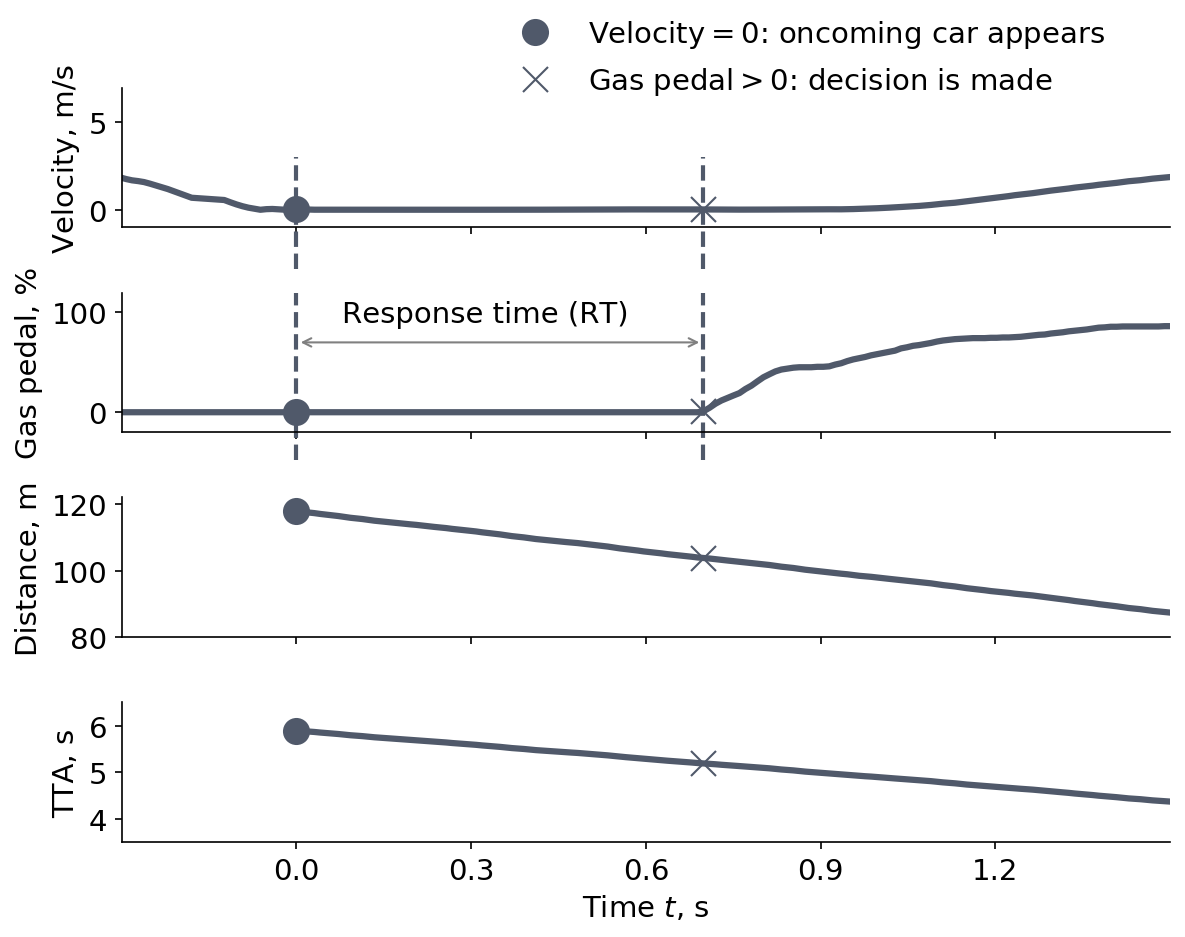

In [172]:
def plot_traj(traj, ax=None):
    color = '#50596A'
    font_size = 14
    ms = 12
    lw = 3
    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    traj.loc[:, 't'] -= traj.t.values[idx_bot_spawn]
    
    fig, axes = plt.subplots(4, 1, figsize=(8,6), dpi=150, sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color=color, lw=lw)
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[0].set_ylabel('Velocity, m/s', fontsize=font_size)
    axes[0].set_ylim((-1, 7))
    
    for x in [traj.t[idx_bot_spawn], traj.t[idx_response]]:
        axes[0].axvline(x=x, ymin=-0.3, ymax=0.5, c=color, ls='--', clip_on=False)
        axes[1].axvline(x=x, ymin=-0.2, ymax=1, c=color, ls='--', clip_on=False)
    
    axes[1].annotate(s='', xy=(traj.t[idx_bot_spawn], 70), xytext=(traj.t[idx_response], 70), 
                     arrowprops=dict(arrowstyle='<->', color='0.5'))
    axes[1].text(.21, .79, 'Response time (RT)', transform=axes[1].transAxes, fontsize=font_size)
    
#     throttle_brake = traj.throttle-traj.brake
    axes[1].plot(traj.t, 100*traj.throttle, color=color, lw=lw)
    axes[1].plot(traj.t[idx_bot_spawn], 100*traj.throttle[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[1].plot(traj.t[idx_response], 100*traj.throttle[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[1].set_ylabel('Gas pedal, %', fontsize=font_size)
    axes[1].set_ylim((-20, 120))
    axes[1].set_yticks([0, 100])

    axes[2].plot(traj.t[idx_bot_spawn:], traj.d_ego_bot[idx_bot_spawn:], color=color, lw=lw)
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[2].set_ylabel('Distance, m', fontsize=font_size)
    axes[2].set_ylim((80, 122))

    axes[3].plot(traj.t[idx_bot_spawn:], traj.tta[idx_bot_spawn:], color=color, lw=lw)
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color=color, ls='', marker='o', 
                 label='Velocity$=0$: oncoming car appears', ms=ms)
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color=color, ls='', marker='x', 
                 label='Gas pedal$>0$: decision is made', ms=ms)
    axes[3].set_ylabel('TTA, s', fontsize=font_size)
    axes[3].set_ylim((3.5, 6.5))
    axes[3].set_yticks([4, 5, 6])

    axes[3].set_xlim((-0.3, 1.5))
    axes[3].set_xticks(np.arange(0, 1.4, 0.3))
    
    axes[3].set_xlabel('Time $t$, s', fontsize=font_size)

    legend = fig.legend(loc='upper left', fontsize=font_size, bbox_to_anchor=(0.4, 1.05), frameon=False)
#     legend.get_title().set_fontsize('16')
    plt.tight_layout()
    
plot_traj(traj)
plt.savefig('../output/fig_trial_timeline.pdf', bbox_inches='tight')

# Model fit against data

In [29]:
model_measures_all_conditions = pd.read_csv(os.path.join(fit_results_path, 'full_data_measures.csv'))

In [52]:
def plot_all_subj_p_turn(ax, exp_data, d_condition, marker, color, marker_offset=0):
    between_subj_mean = exp_data[(exp_data.d_condition==d_condition)].groupby(['subj_id', 'tta_condition']).mean()
    data_subj_d_measures = get_mean_sem(between_subj_mean.reset_index(), var='is_turn_decision', n_cutoff=2)
    ax.errorbar(data_subj_d_measures.index+marker_offset, data_subj_d_measures['mean'], yerr=data_subj_d_measures['sem'], 
                    ls='', marker=marker, ms=9, color=color)
    
def plot_subj_p_turn(ax, exp_data, d_condition, subj_id, marker, color):
    data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]
    psf_ci = get_psf_ci(data_subj_d_measures)
    ax.plot(psf_ci.tta_condition, psf_ci.p_turn, ls='', marker=marker, ms=9, color=color, zorder=10)
    ax.vlines(x=psf_ci.tta_condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)

def plot_subj_rt(ax, exp_data, d_condition, subj_id, marker, color, marker_offset=0):
    if subj_id=='all':
        between_subj_mean = exp_data[(exp_data.d_condition==d_condition) & (exp_data.is_turn_decision)].groupby(['subj_id', 'tta_condition']).mean()
        measures = between_subj_mean.reset_index()
    else:
        measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition) & (exp_data.is_turn_decision)]

    if len(measures)>0:
        measures_mean_sem = get_mean_sem(measures, var='RT', n_cutoff=2)
        ax.errorbar(measures_mean_sem.index+marker_offset, measures_mean_sem['mean'], yerr=measures_mean_sem['sem'], 
                        ls='', marker=marker, ms=9, color=color)
    
def plot_compare_model_exp(var, exp_data, model_measures, ylabel):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({'subj_id': str})
    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    markers=['o', 's', '^']
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    
    subjects = model_measures.subj_id.unique()
    
    fig, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

    for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
        ax.set_title('All participants' if subj_id=='all' else 'P%s' % (subj_idx+1), fontsize=16)
        for d_condition, color, marker in zip(d_conditions, colors, markers):
            model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                                   & (model_measures.d_condition==d_condition)]         
            
            if var=='is_turn_decision':
                # Model
                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], 
                    color=color, label=d_condition)
                
                # Data
                # for all subjects, use scipy's sem estimates, since we average over continuous measures (p_turn)
                if subj_id=='all':
                    plot_all_subj_p_turn(ax, exp_data, d_condition, marker, color)
                # for individual subjects, use binomial proportion sem estimates, since we average over binary measures (p_turn)
                else:
                    plot_subj_p_turn(ax, exp_data, d_condition, subj_id, marker, color)

            elif var=='RT':                
                # Model
                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], color=color, label=d_condition)

                # Data
                plot_subj_rt(ax, exp_data, d_condition, subj_id, marker, color)
                
                ax.set_xticklabels([4, 5, 6])
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])
            else:
                raise(ValueError)

        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0, label='Data, d=%im' % (d_condition)) 
                       for d_condition, color, marker in zip(d_conditions, colors, markers)] 
                       + [Line2D([0], [0], color='grey', label='Model')])

    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.15, 0.55), fontsize=16, frameon=False)

    fig.text(0.4, -0.05, 'Time-to-arrival (TTA), s', fontsize=18)
    fig.text(-0.02, 0.3, ylabel, fontsize=18, rotation=90)

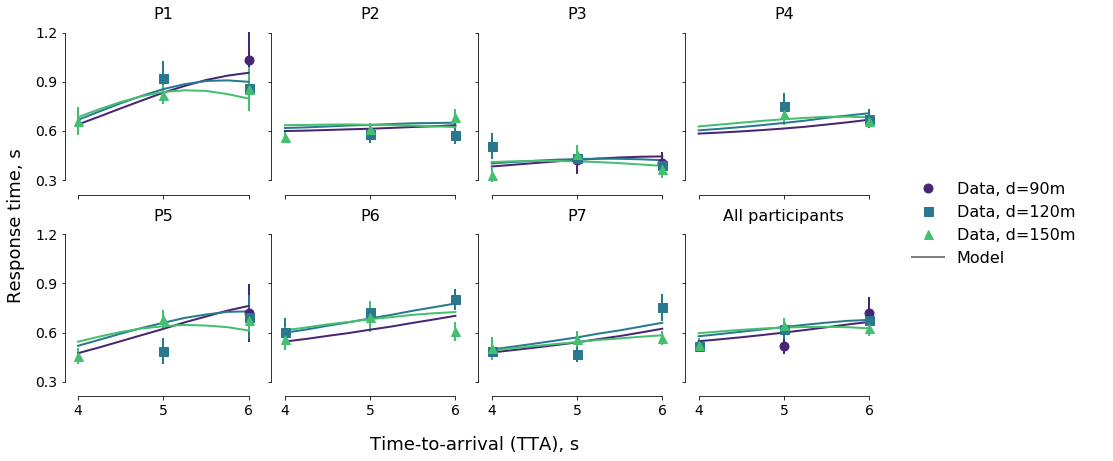

In [53]:
plot_compare_model_exp('RT', exp_measures, model_measures_all_conditions, 'Response time, s')
plt.savefig('../output/fig_RT_final.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d


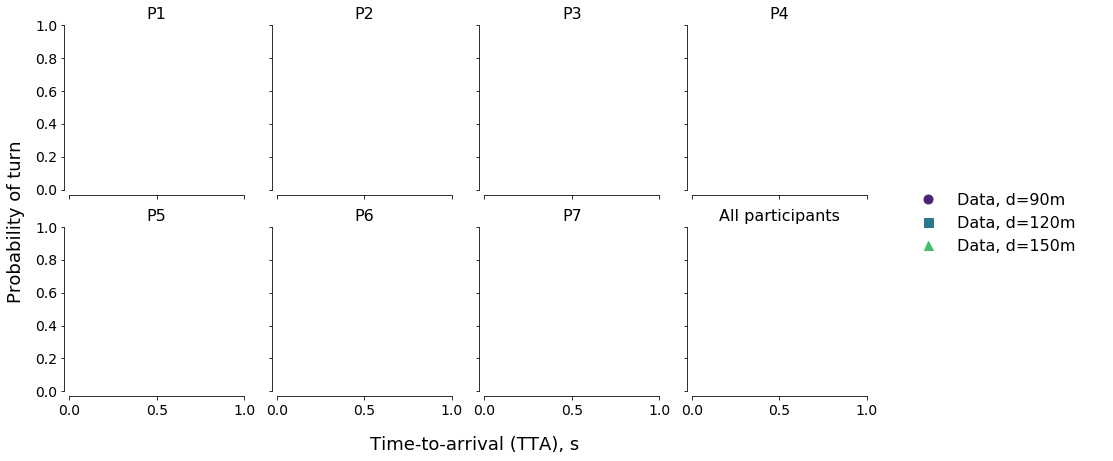

In [48]:
plot_compare_model_exp('is_turn_decision', exp_measures, model_measures_all_conditions, 'Probability of turn')
plt.savefig('../output/fig_p_turn_2.png', bbox_inches='tight')

In [39]:
def plot_all_subj_p_turn(ax, exp_data, d_condition, marker, color, marker_offset=0):
    between_subj_mean = exp_data[(exp_data.d_condition==d_condition)].groupby(['subj_id', 'tta_condition']).mean()
    data_subj_d_measures = get_mean_sem(between_subj_mean.reset_index(), var='is_turn_decision', n_cutoff=2)
    ax.errorbar(data_subj_d_measures.index+marker_offset, data_subj_d_measures['mean'], yerr=data_subj_d_measures['sem'], 
                    ls='', marker=marker, ms=9, color=color)
    
def plot_subj_p_turn(ax, exp_data, d_condition, subj_id, marker, color):
    data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]
    psf_ci = get_psf_ci(data_subj_d_measures)
    ax.plot(psf_ci.tta_condition, psf_ci.p_turn, ls='', marker=marker, ms=9, color=color, zorder=10)
    ax.vlines(x=psf_ci.tta_condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)

def plot_subj_rt(ax, exp_data, d_condition, subj_id, marker, color, marker_offset=0):
    if subj_id=='all':
        between_subj_mean = exp_data[(exp_data.d_condition==d_condition) & (exp_data.is_turn_decision)].groupby(['subj_id', 'tta_condition']).mean()
        measures = between_subj_mean.reset_index()
    else:
        measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition) & (exp_data.is_turn_decision)]

    if len(measures)>0:
        measures_mean_sem = get_mean_sem(measures, var='RT', n_cutoff=2)
        ax.errorbar(measures_mean_sem.index+marker_offset, measures_mean_sem['mean'], yerr=measures_mean_sem['sem'], 
                        ls='', marker=marker, ms=9, color=color)
    
def plot_compare_model_exp(var, exp_data, model_measures, ylabel):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({'subj_id': str})
    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    markers=['o', 's', '^']
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    
    subjects = model_measures.subj_id.unique()
    
    # plot axes only
    fig, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

    fig.text(0.4, -0.05, 'Time-to-arrival (TTA), s', fontsize=18)
    fig.text(-0.02, 0.3, ylabel, fontsize=18, rotation=90)
    for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
        ax.set_title('All participants' if subj_id=='all' else 'P%s' % (subj_idx+1), fontsize=16)
        for d_condition, color, marker in zip(d_conditions, colors, markers):
            if var=='RT':                
                ax.set_xticklabels([4, 5, 6])
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])
        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    plt.savefig('../output/fig_p_turn_1.png', bbox_inches='tight')
    
    # then plot data only
    for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
        for d_condition, color, marker in zip(d_conditions, colors, markers):
            if var=='is_turn_decision':
                # Data
                # for all subjects, use scipy's sem estimates, since we average over continuous measures (p_turn)
                if subj_id=='all':
                    plot_all_subj_p_turn(ax, exp_data, d_condition, marker, color)
                # for individual subjects, use binomial proportion sem estimates, since we average over binary measures (p_turn)
                else:
                    plot_subj_p_turn(ax, exp_data, d_condition, subj_id, marker, color)

            elif var=='RT':                
                # Data
                plot_subj_rt(ax, exp_data, d_condition, subj_id, marker, color)
    
    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0, label='Data, d=%im' % (d_condition)) 
                       for d_condition, color, marker in zip(d_conditions, colors, markers)])

    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.15, 0.55), fontsize=16, frameon=False)
    plt.tight_layout()

    plt.savefig('../output/fig_p_turn_2.png', bbox_inches='tight')
    
    # second plot model fits on top of the data
#     for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
#         for d_condition, color, marker in zip(d_conditions, colors, markers):
#             model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
#                                                    & (model_measures.d_condition==d_condition)]         
            
#             if var=='is_turn_decision':
#                 # Model
#                 ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], 
#                     color=color, label=d_condition)
#             elif var=='RT':                
#                 # Model
#                 ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], color=color, label=d_condition)

#     legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0, label='Data, d=%im' % (d_condition)) 
#                        for d_condition, color, marker in zip(d_conditions, colors, markers)] 
#                        + [Line2D([0], [0], color='grey', label='Model')])

#     fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.15, 0.55), fontsize=16, frameon=False)
#     plt.tight_layout()

#     plt.savefig('../output/fig_p_turn_3.png', bbox_inches='tight')

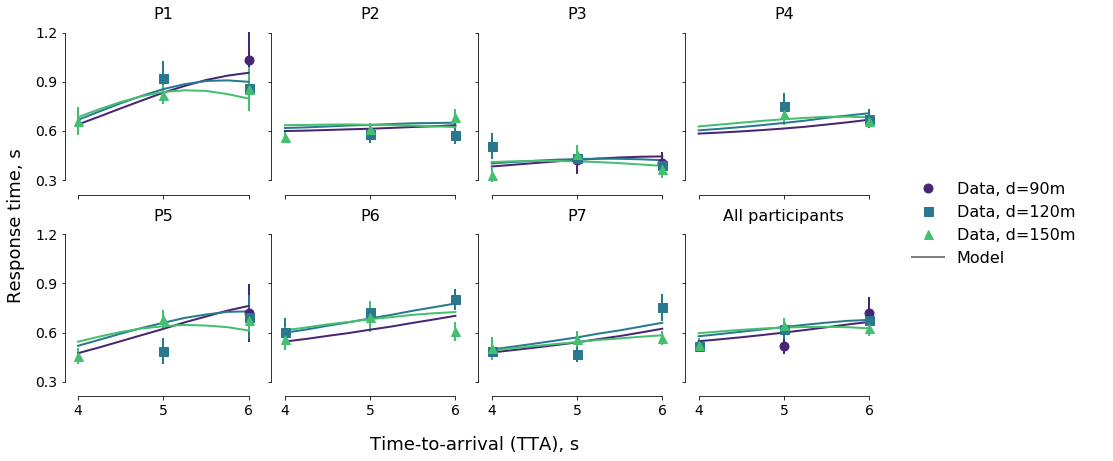

In [19]:
plot_compare_model_exp('RT', exp_measures, model_measures_all_conditions, 'Response time, s')
plt.savefig('../output/fig_RT.pdf', bbox_inches='tight')

# RT distributions

In [59]:
def plot_condition_vincentized_dist(ax, condition, condition_data):
    colors = dict(zip([90,120,150], [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,3)]))
    markers={90: 'o', 120: 's', 150: '^'}
    q = [0.1, 0.3, 0.5, 0.7, 0.9]
    #     q = np.linspace(0.01, 0.99, 10)
    condition_quantiles = condition_data.groupby('subj_id').apply(lambda d: np.quantile(a=d.RT, q=q)).mean()

    rt_range = np.linspace(condition_quantiles.min(), condition_quantiles.max(), len(q))
    step = rt_range[1] - rt_range[0]
    rt_grid = np.concatenate([rt_range[:3]-3*step, rt_range, rt_range[-3:]+step*3])
    vincentized_cdf = np.interp(rt_grid, condition_quantiles, q, left=0, right=1)

    ax.plot(rt_grid, vincentized_cdf, label='Data', color=colors[condition['d']], 
            ls='', ms=7, marker=markers[condition['d']])
    ax.set_ylim([-0.05, 1.1])
    ax.set_yticks([0.0, 0.5, 1.0])

def decorate_axis(ax, condition):
    if (((condition['d'] == 90) & (condition['TTA'] == 6)) 
        | ((condition['d'] == 120) & (condition['TTA'] == 5)) 
        | ((condition['d'] == 150) & (condition['TTA'] == 4))):
        ax.text(0.5, 1.02, 'TTA=%is' % condition['TTA'], fontsize=16, transform=ax.transAxes, 
                    horizontalalignment='center', verticalalignment='center')

    if condition['TTA'] == 6:
        ax.text(1.0, 0.5, 'd=%im' % condition['d'], fontsize=16, transform=ax.transAxes, rotation=-90, 
            horizontalalignment='center', verticalalignment='center')
    
def plot_vincentized_dist(exp_data, model_rts):
    fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)
    conditions = [{'d': d, 'TTA': TTA}
                  for d in sorted(exp_data.d_condition.unique()) 
                  for TTA in sorted(exp_data.tta_condition.unique())]
    
    for (ax, condition) in zip(axes.flatten(), conditions):
        condition_data = exp_data[(exp_data.is_turn_decision) 
                            & (exp_data.d_condition==condition['d']) 
                            & (exp_data.tta_condition==condition['TTA'])]
        if len(condition_data) >= 25:       
            # Group-averaged data
            plot_condition_vincentized_dist(ax, condition, condition_data)
            
            # Model
            if not model_rts is None:
                condition_rts = model_rts[(model_rts.subj_id=='all') 
                                        & (model_rts.d_condition==condition['d']) 
                                        & (model_rts.tta_condition==condition['TTA'])]
                ax.plot(condition_rts.t, condition_rts.rt_corr_distr, label='Model', color='grey')
        else:
            ax.set_axis_off()

        decorate_axis(ax, condition)
        
        ax.set_xlabel('')
        ax.set_xlim((0, 1.5))
        sns.despine(offset=5, trim=True)
        
    legend_elements = ([Line2D([0], [0], color='grey', marker='*', ms=9, lw=0, label='Group-averaged data'), 
                        Line2D([0], [0], color='grey', label='Model')])
    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.25, 0.75), fontsize=16, frameon=True)    

    fig.text(0.43, 0.04, 'Response time', fontsize=16)
    fig.text(0.04, 0.2, 'CDF', fontsize=16, rotation=90)
    
    return fig, axes

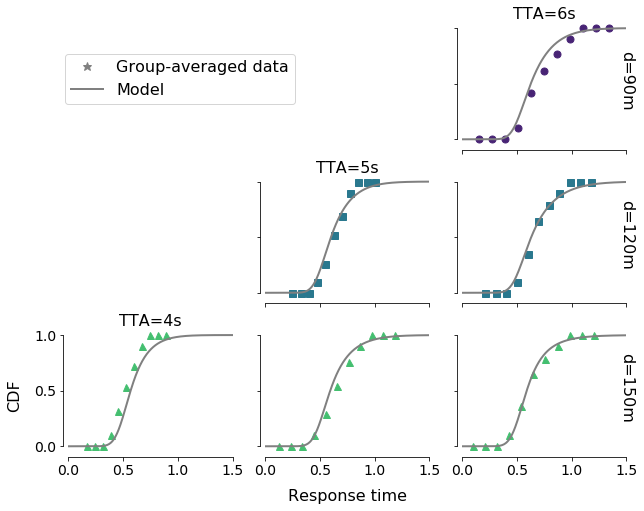

In [60]:
model_rts = pd.read_csv(os.path.join(fit_results_path, 'full_data_rt_cdf.csv'))
fig, axes = plot_vincentized_dist(exp_measures, model_rts)
plt.savefig('../output/fig_RT_dist_final.png', bbox_inches='tight')

# Model cross-validation

In [71]:
def plot_cross_validation_per_subj(exp_data, model_measures, subj_id):
    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    markers=['o', 's', '^']
    marker_size=9
    marker_offset = 0.1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    
    if not subj_id=='all':
        fig.suptitle('P%s' % (subj_id), fontsize=16)
    
    for d_condition, marker, color in zip(d_conditions, markers, colors):
        model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                               & (model_measures.d_condition==d_condition)]
        # Model
        ax1.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures['is_turn_decision'], 
                    color=color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size, fillstyle='none')  
        ax2.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures['RT'], 
                color=color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size, fillstyle='none')

        # Data
        plot_all_subj_p_turn(ax1, exp_data, d_condition, marker, color, -marker_offset)
        plot_subj_rt(ax2, exp_data, d_condition, subj_id, marker, color, -marker_offset)

    fig.text(0.35, -0.05, 'Time-to-arrival (TTA), s', fontsize=16)
    
    ax1.set_xticks([4, 5, 6])
    ax2.set_xticks([4, 5, 6])
    
    ax1.legend().remove()
    ax2.legend().remove()
    
    ax1.set_ylabel('Probability of turn', fontsize=16)
    ax2.set_ylabel('Response time', fontsize=16)

    ax1.set_ylim((0.0, 1.0))
    
    ax2.set_ylim((0.4, 0.8))
    
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=1, ls='--', fillstyle='none', label='Model predictions,') 
                           for d_condition, marker, color in zip(d_conditions, markers, colors)] 
                       + [Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=0, label='data, d=%im' % (d_condition)) 
                           for d_condition, marker, color in zip(d_conditions, markers, colors)])

    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16, handlelength=1.5, columnspacing=0.2,
               frameon=False, ncol=2)

In [63]:
model_measures_cross_validation_8 = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_8_measures.csv'))

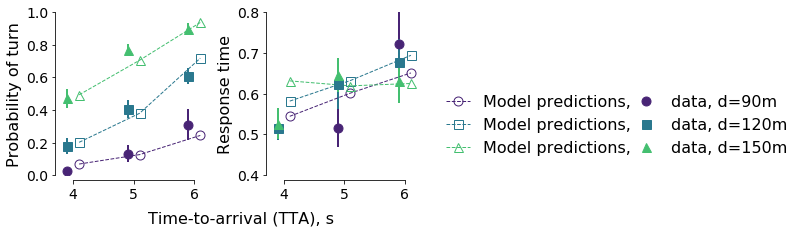

In [72]:
plot_cross_validation_per_subj(exp_measures, model_measures_cross_validation_8, subj_id='all')
plt.savefig('../output/fig_cross_validation_8_vincent_3.png', bbox_inches='tight')

# Supplementary cross-validation figures

### Cross-validation per participant

In [39]:
def plot_cross_validation_all_subj(exp_data, model_measures):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({'subj_id': str})

    d_conditions = [90, 120, 150]
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    markers=['o', 's', '^']
    data_color='grey'
    model_color='grey'
    marker_size=10
    marker_offset = 0.1
    
    subjects = exp_data.subj_id.unique()
    subfigures = [(var, subj_id) for var in ['is_turn_decision', 'RT'] for subj_id in subjects]
    
    fig, axes = plt.subplots(2, 7, figsize=(14,6), sharex='col', sharey='row')

    for (var, subj_id), ax in zip(subfigures, axes.flatten()):
        if var=='is_turn_decision':
            ax.set_title('All participants' if subj_id=='all' else 'P%s' % (subj_id), fontsize=16)
        for d_condition, marker, color in zip(d_conditions, markers, colors):
            model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                                   & (model_measures.d_condition==d_condition)]
            
            if subj_id == 'all':
                data_subj_d_measures = exp_data[(exp_data.d_condition==d_condition)]
            else:
                data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]
            
            if var=='is_turn_decision':
                # Model
                ax.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures[var], 
                            color=color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size, fillstyle='none')  
                
                # Data
                psf_ci = get_psf_ci(data_subj_d_measures)     
                ax.plot(psf_ci.tta_condition-marker_offset, psf_ci.p_turn, ls='', lw=1, marker=marker, 
                        ms=marker_size, color=color, zorder=10)
                ax.vlines(x=psf_ci.tta_condition-marker_offset, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, 
                          color=color, alpha=0.6, zorder=10)
            elif var=='RT':
                # Model
                ax.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures[var], 
                        color=color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size, fillstyle='none')
                
                # Data
                data_subj_d_measures = data_subj_d_measures[data_subj_d_measures.is_turn_decision]
                if len(data_subj_d_measures)>0:
                    data_mean_sem = get_rt_mean_sem(data_subj_d_measures)
                    ax.errorbar(data_mean_sem.index-marker_offset, data_mean_sem.RT_mean, yerr=data_mean_sem.RT_sem, 
                                ls='', lw=1, marker=marker, ms=marker_size, color=color, ecolor=color)
                ax.set_ylim((0.3, 1.2))
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])

            else:
                raise(ValueError)

        ax.set_xticks([4, 5, 6])
        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=1, ls='--', fillstyle='none', label='Model predictions,') 
                           for d_condition, marker, color in zip(d_conditions, markers, colors)] 
                       + [Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=0, label='data, d=%im' % (d_condition)) 
                           for d_condition, marker, color in zip(d_conditions, markers, colors)])

    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.0, 1.3), fontsize=16, handlelength=1.5, columnspacing=0.2,
               frameon=False, ncol=2)

    fig.text(0.4, -0.05, 'Time-to-arrival (TTA), s', fontsize=16)
    fig.text(-0.01, 0.55, 'Probability of turn', fontsize=16, rotation=90)
    fig.text(-0.01, 0.15, 'Response time', fontsize=16, rotation=90)

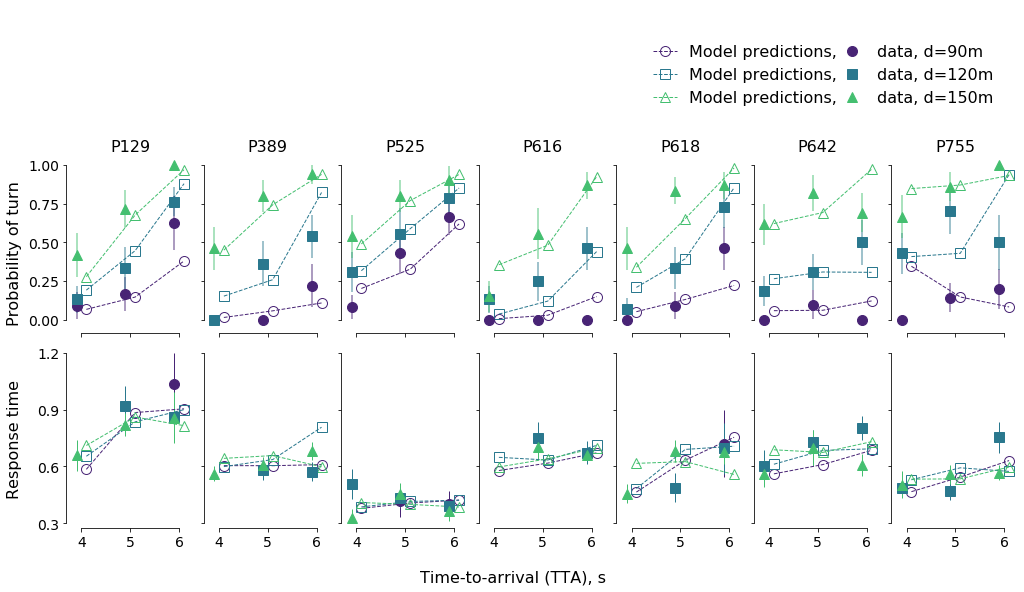

In [40]:
plot_cross_validation_all_subj(exp_measures, model_measures_cross_validation_8)
plt.savefig('../output/fig_cross_validation_8.pdf', bbox_inches='tight')

### Cross-validation on 4 conditions

In [ ]:
model_measures_cross_validation_4 = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_4_measures.csv'))

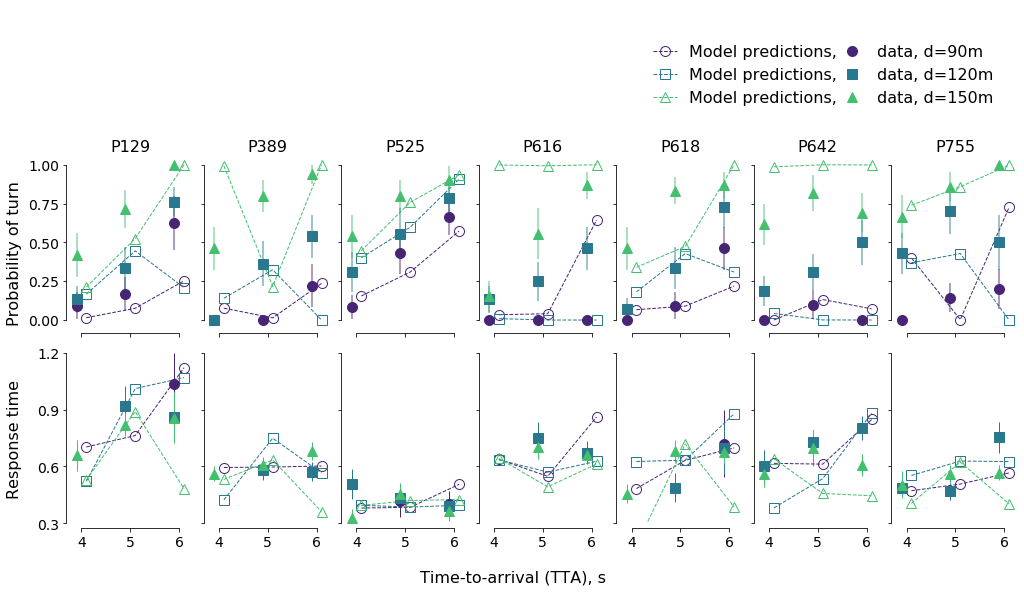

In [127]:
plot_cross_validation(exp_measures, model_measures_cross_validation_4)

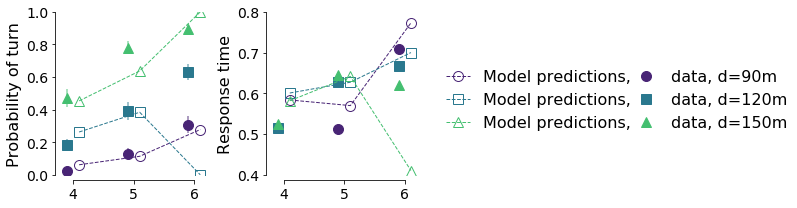

In [128]:
plot_cross_validation_per_subj(exp_measures, model_measures_cross_validation_4, subj_id='all')